### Importing Libraries

In [2]:
#!pip install pyspark
import pyspark
from pyspark.sql import SQLContext, Row, column
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Defining Sparksession

In [5]:
#sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)
spark = SparkSession \
    .builder \
    .appName("Yelp") \
    .getOrCreate()
sqlContext = SQLContext(sc)

### Loading JSON files as Dataframes

In [7]:
sqlContext = SQLContext(sc)
business = "yelp_academic_dataset_business.json"
checkin = "yelp_academic_dataset_checkin.json"
review = "yelp_academic_dataset_review.json"
tip = "yelp_academic_dataset_tip.json"

df_business = sqlContext.read.json(business)
#df_checkin = sqlContext.read.json(checkin)
#df_review = sqlContext.read.json(review)
#df_tip = sqlContext.read.json(tip)

df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

### City with Most Number of Restaurants

In [168]:
tmp = df_business.groupBy("city").count()
tmp = tmp.orderBy("count", ascending=False)
tmp = tmp.withColumnRenamed('count', 'total_count')
tmp = tmp.toPandas()
tmp.describe()
tmp.head(10)

,city,total_count
0,Las Vegas,28865
1,Phoenix,18633
2,Toronto,18233
3,Charlotte,9204
4,Scottsdale,8822
5,Calgary,7384
6,Pittsburgh,6804
7,Mesa,6239
8,Montréal,6045
9,Henderson,4815


### States with Top Restaurant Counts

In [120]:
tmp = df_business.groupBy("state").count()
tmp = tmp.orderBy("count", ascending=False)
tmp = tmp.withColumnRenamed('count', 'total_count')
tmp = tmp.toPandas()
tmp.describe()
tmp.head(10)

,state,total_count
0,AZ,56495
1,NV,35688
2,ON,32393
3,NC,14359
4,OH,13664
5,PA,10966
6,QC,8756
7,AB,7670
8,WI,5042
9,IL,1937


### Number of Reviews per Restaurant

In [8]:
review_df = sqlContext.read.json(review)
review_df = review_df.na.drop()
#rdd = review_df.rdd.map(tuple)
review_df = review_df.groupBy("business_id").count()
review_df = review_df.withColumnRenamed('count', 'review_count')
review_df = review_df.sort("review_count", ascending=False)

In [33]:
review_df.show(5)

+--------------------+------------+
|         business_id|review_count|
+--------------------+------------+
|4JNXUYY8wbaaDmk3B...|        7968|
|RESDUcs7fIiihp38-...|        7861|
|K7lWdNUhCbcnEvI0N...|        6447|
|cYwJA2A6I12KNkm2r...|        5472|
|f4x1YBxkLrZg652xt...|        5382|
+--------------------+------------+
only showing top 5 rows



### Review Counts less than 100

In [10]:
tmp = review_df.toPandas()
tmp = tmp[tmp.review_count<50]
tmp.count()

business_id     163426
review_count    163426
dtype: int64

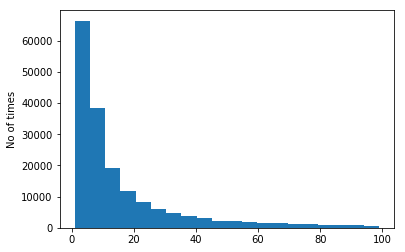

In [11]:
tmp = review_df.toPandas()
tmp = tmp[tmp.review_count<100]
plt.hist(tmp["review_count"], bins=20)
plt.ylabel('No of times')
plt.show()

### Number of Tips per Restaurant

In [12]:
tip_df = sqlContext.read.json(tip)
tip_df = tip_df.na.drop()
tip_df = tip_df.groupBy("business_id").count()
tip_df = tip_df.withColumnRenamed('count', 'tip_count')
tip_df = tip_df.sort("tip_count", ascending=False)

In [13]:
tip_df.show(5)

+--------------------+---------+
|         business_id|tip_count|
+--------------------+---------+
|FaHADZARwnY4yvlvp...|     3581|
|JmI9nslLD7KZqRr__...|     2420|
|DkYS3arLOhA8si5uU...|     1492|
|5LNZ67Yw9RD6nf4_U...|     1467|
|hihud--QRriCYZw1z...|     1428|
+--------------------+---------+
only showing top 5 rows



In [17]:
tmp = tip_df.toPandas()
tmp = tmp[tmp.tip_count<50]
tmp.count()

business_id    117265
tip_count      117265
dtype: int64

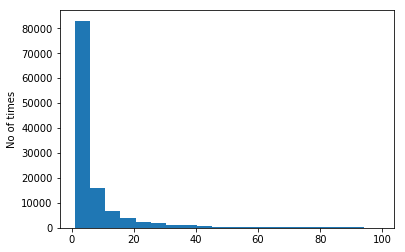

In [71]:
tmp = tip_df.toPandas()
tmp = tmp[tmp.tip_count<100]
plt.hist(tmp["tip_count"], bins=20)
plt.ylabel('No of times')
plt.show()

### Number of Checkins per Restaurant

In [18]:
def process_tuple(tup):
    business_id = tup[0]
    time = tup[1]
    summ=0
    for val in time:
        if val != None:
            summ+=val
    return Row(business_id=business_id,checkin_count=summ)
    
checkin_df = sqlContext.read.json(checkin) # business_id is primary key
rdd = checkin_df.rdd.map(tuple)
rdd = rdd.map(process_tuple)
checkin_df = spark.createDataFrame(rdd)
checkin_df = checkin_df.sort("checkin_count", ascending=False)
checkin_df.show(5)

+--------------------+-------------+
|         business_id|checkin_count|
+--------------------+-------------+
|FaHADZARwnY4yvlvp...|       138477|
|JmI9nslLD7KZqRr__...|       118185|
|yQab5dxZzgBLTEHCw...|        52675|
|5LNZ67Yw9RD6nf4_U...|        45416|
|IZivKqtHyz4-ts8Ks...|        36327|
+--------------------+-------------+
only showing top 5 rows



In [19]:
tmp = checkin_df.toPandas()
tmp = tmp[tmp.checkin_count<50]
tmp.count()

business_id      112081
checkin_count    112081
dtype: int64

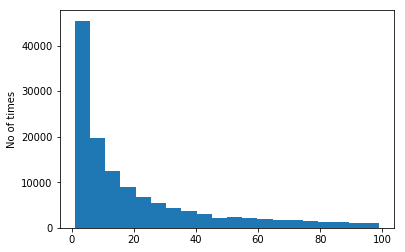

In [72]:
tmp = checkin_df.toPandas()
tmp = tmp[tmp.checkin_count<100]
plt.hist(tmp["checkin_count"], bins=20)
plt.ylabel('No of times')
plt.show()

### Joined Review, Tip and Checkin counts

In [75]:
#Joining results
ta = checkin_df.alias('ta')
tb = tip_df.alias('tb')
#tc = review_df.alias('tc')
innerJoin = ta.join(tb, ta.business_id == tb.business_id).drop(tb.business_id)
#innerJoin = innerJoin.join(tc, innerJoin.business_id == tc.business_id).drop(tc.business_id)
innerJoin.show(5)

+--------------------+-------------+---------+
|         business_id|checkin_count|tip_count|
+--------------------+-------------+---------+
|--9e1ONYQuAa-CB_R...|         2699|      154|
|-6c_bJblLXUwoWfmY...|            7|        2|
|-ElDqujEn1u64ynQr...|            2|        1|
|-I06hkMFrX0KBqu61...|           37|        1|
|-TGwtTiieh_JLml5_...|           52|        6|
+--------------------+-------------+---------+
only showing top 5 rows



In [22]:
business_df = sqlContext.read.json(business)
business_df.toPandas().count()


address         188593
attributes      162807
business_id     188593
categories      188052
city            188593
hours           143791
is_open         188593
latitude        188587
longitude       188587
name            188593
neighborhood    188593
postal_code     188593
review_count    188593
stars           188593
state           188593
dtype: int64

In [76]:
business_df = sqlContext.read.json(business)
ta = innerJoin.alias('ta')
tb = business_df.alias('tb')
bigTable = ta.join(tb, ta.business_id == tb.business_id).drop(tb.business_id)
bigTable = bigTable.na.drop()
bigTable.show(5)

+--------------------+-------------+---------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+-----------+--------------------+------------+-----------+------------+-----+-----+
|         business_id|checkin_count|tip_count|             address|          attributes|          categories|         city|               hours|is_open|  latitude|  longitude|                name|neighborhood|postal_code|review_count|stars|state|
+--------------------+-------------+---------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+-----------+--------------------+------------+-----------+------------+-----+-----+
|--9e1ONYQuAa-CB_R...|         2699|      154|3355 Las Vegas Bl...|[,, full_bar, {'r...|Steakhouses, Rest...|    Las Vegas|[11:30-14:0, 11:3...|      1| 36.123183| -115.16919|Delmonico Steakhouse|   The Strip|      89109|        1546|  4.0|   NV|
|-TGwtTiieh_

In [77]:
sum_cols = ['checkin_count', 'review_count','tip_count']
review_checkin_tip = bigTable.groupBy('city').sum(*sum_cols)

+--------------------+------------------+-----------------+--------------+
|                city|sum(checkin_count)|sum(review_count)|sum(tip_count)|
+--------------------+------------------+-----------------+--------------+
|         Middlefield|               264|              184|            30|
|       Harrison City|                93|               75|            24|
|Saint-Marc-sur-Ri...|                 8|                8|             1|
|               Tempe|            555236|           156245|         34103|
|          Harrisburg|              2845|             1140|           301|
|        Sainte-Adele|                 7|                6|             2|
|      Île des Soeurs|                86|               43|            12|
|     North Las Vegas|            113382|            35578|          9285|
|        Saint-Hubert|                71|               86|            21|
|       Lawrenceville|               488|              208|            40|
|         C Las Vegas|   

In [79]:
review_df.show(5)

+--------------------+------------+
|         business_id|review_count|
+--------------------+------------+
|4JNXUYY8wbaaDmk3B...|        7968|
|RESDUcs7fIiihp38-...|        7861|
|K7lWdNUhCbcnEvI0N...|        6447|
|cYwJA2A6I12KNkm2r...|        5472|
|f4x1YBxkLrZg652xt...|        5382|
+--------------------+------------+
only showing top 5 rows

